In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import copy
import pickle
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import dataset as dt

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

from core.losses import score

### load data

In [67]:
# load dataset
dataset = dt.XTXDataset()
dataset.delete_invalid_rows()

Time series length: 2999999


In [4]:
def acf(data, lag=None):
    n = len(data)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2)
    
    def r(h):
        return np.sum((data[:n-h] - mean) * (data[h:] - mean)) / c0
    
    res = []
    for l in lag:
        res.append(r(l))
    plt.plot(lag, res)
    plt.show()
    
    return res

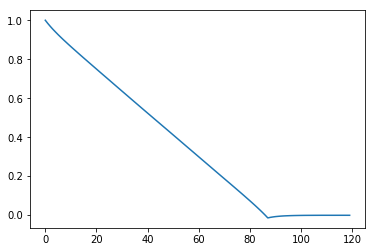

In [50]:
res = acf(dataset.label_y, lag=np.arange(0, 120, 1))

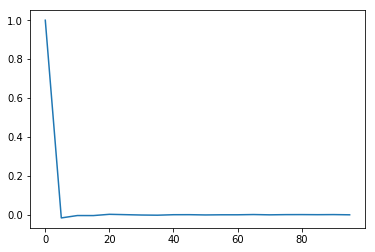

In [5]:
res = acf(np.diff(dataset.mid_rate), lag=np.arange(0, 100, 5))

In [7]:
# res

In [ ]:
mid_rate = dataset.mid_rate
autocorrelation_plot(mid_rate)
plt.show()

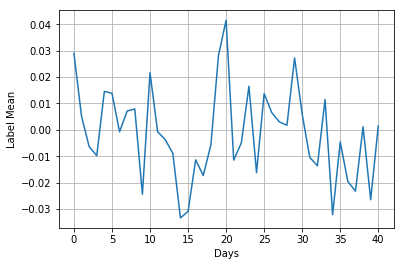

In [61]:
diff_label = dataset.label_y
means = []
for i in range(len(dt.days_index_nonzero)):
    mean = np.mean(diff_label[dt.days_index_nonzero[i]:dt.days_index[i+1]])
    means.append(mean)
plt.plot(means)
plt.xlabel("Days")
plt.ylabel("Label Mean")
plt.grid()
plt.show()

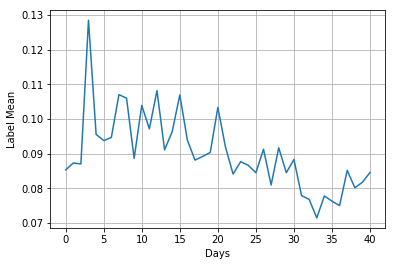

In [35]:
diff_label = np.diff(dataset.mid_rate)
means = []
for i in range(len(dt.days_index_nonzero)):
    mean = np.std(diff_label[dt.days_index_nonzero[i]:dt.days_index[i+1]])
    means.append(mean)
plt.plot(means)
plt.xlabel("Days")
plt.ylabel("Label Mean")
plt.grid()
plt.show()

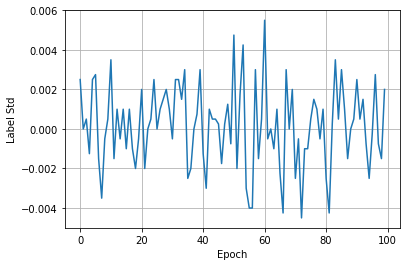

In [78]:
stds = []
n = len(dataset.label_y)
diff_label = np.diff(dataset.mid_rate)
# diff_label = dataset.label_y
step = 1000
for i in range(n // step):
    stds.append(np.mean(diff_label[i*step:i*step+step]))
plt.plot(stds[:100])
plt.xlabel("Epoch")
plt.ylabel("Label Std")
plt.grid()
plt.show()

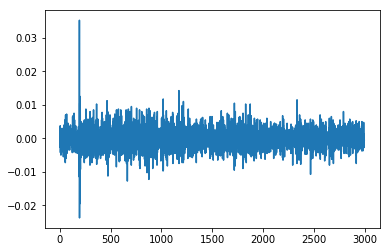

In [79]:
plt.plot(np.diff(np.asarray(stds)))
plt.show()

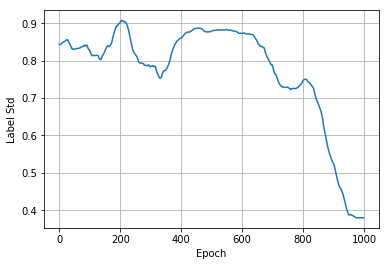

In [121]:
stds = []
# diff_label = np.diff(dataset.mid_rate)
diff_label = dataset.label_y
n = len(diff_label)
step = 1
clen = 500
for i in range(n // 1000):
    stds.append(np.std(diff_label[i*step : i*step+clen]))
plt.plot(stds[:1000])
plt.xlabel("Epoch")
plt.ylabel("Label Std")
plt.grid()
plt.show()

In [134]:
for i in range(100):
#     print(stds[i], stds[i+87])
    pass

### score by day

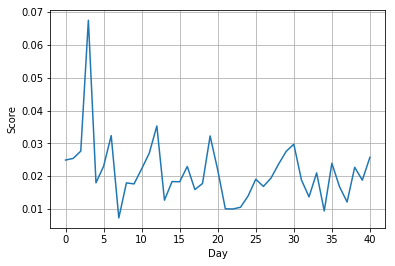

In [60]:
from xtx_model import BaseMLP
from xtx_config import XTX_Config
from core.dataset_utils import volume_data
from core.losses import score

mlp_model = BaseMLP(XTX_Config)
mlp_model.compile()
mlp_model._model.load_weights("datas/weights/scale_2_lastdense_512_val_202_test_199.hdf5")

x, y = volume_data(dataset, XTX_Config["time_steps"], norm_window_size=1, levels=5, split=False)

scores = []
for i in range(len(dt.days_index_nonzero)):
    _x = x[dt.days_index_nonzero[i] : dt.days_index[i+1]]
    _y = y[dt.days_index_nonzero[i] : dt.days_index[i+1]]
    scores.append(score(_y, mlp_model.predict(_x)))

plt.plot(scores)
plt.xlabel("Day")
plt.ylabel("Score")
plt.grid()
plt.show()

### label standardization

In [3]:
raw_dataset = dt.XTXDataset()
raw_dataset.delete_invalid_rows()

Time series length: 2999999


In [135]:
from core.dataset_utils import data_sliding

def volume_data_stand_label(datas, 
                            time_steps=15, 
                            norm_window_size=1, 
                            levels=5, 
                            delay=87, 
                            std_step=500, 
                            std_ref=500):
    features = copy.copy(datas.features[:-delay])
    label_y = datas.mid_rate[delay:] - datas.mid_rate[:-delay]
    
    # get x
    ask_rate = np.log10(features[..., 15:15 + levels])
    bid_rate = np.log10(features[..., 45:45 + levels])
    x = np.concatenate([ask_rate, bid_rate], axis=-1)
    # label standardization
    means = np.zeros_like(label_y)
    stds = np.ones_like(label_y)
    block = len(label_y) // std_step - std_ref // std_step
    for i in range(block):
        gslice = slice(i*std_step, std_ref - delay + i*std_step)
        pslice = slice(std_ref + i*std_step, std_ref + (i+1)*std_step)
#         pslice = slice((i+1)*std_step, (i+2)*std_step)
#         pslice = gslice
        rmean = np.mean(label_y[gslice])
        rstd = np.std(label_y[gslice])
        if rstd == 0:
            means[pslice] = label_y[pslice]
        else:
            means[pslice] = rmean
        stds[pslice] = rstd
    stand_y = (label_y - means) / (stds + 1e-6)
    
    # sliding data
    x, y = data_sliding(x, stand_y, time_step=time_steps + norm_window_size - 1)

    return x, y, label_y[time_steps-1:], means[time_steps-1:], stds[time_step-1:]

def volume_data_stand_y_days(datas, indexs):
    pass


def xtx_split(inputs, indexs, start_day, end_day, sampling=5):
    # start_day, end_day range from [0, 40]
    gslice = slice(indexs[start_day], indexs[end_day], sampling)
    return [ins[gslice] for ins in inputs]

IndentationError: expected an indented block (<ipython-input-135-3061785a0787>, line 43)

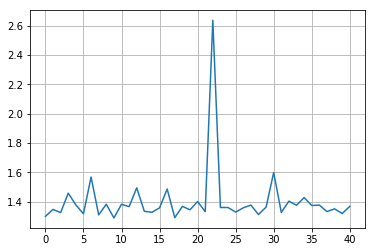

In [126]:
# data setting
time_step, delay, std_step, std_ref = 15, 87, 1, 587
train_days, val_days, test_days = 25, 5, 11
sampling = 5

# get day index
days_start_index = raw_dataset.days_start_index()
days_start_index[1:] -=  (delay + time_step + 1)

# process data
datas = volume_data_stand_label(raw_dataset, time_steps=time_step, std_step=std_step, std_ref=std_ref)
# view mean & std
# y - datas[1]
indexs = list(days_start_index) + [len(datas[1])]
rstds  = [np.std(datas[1][indexs[i]:indexs[i+1]]) for i in range(len(indexs)-1)]
rmeans = [np.mean(datas[1][indexs[i]:indexs[i+1]]) for i in range(len(indexs)-1)]
plt.plot(rstds)
# plt.plot(rmeans)
plt.grid()
plt.show()

# split data to (train, val, test)
days   = np.cumsum(np.asarray([0, train_days, val_days, test_days]))
trains = xtx_split(datas, days_start_index, days[0], days[1]-1)
vals   = xtx_split(datas, days_start_index, days[1], days[2]-1)
tests  = xtx_split(datas, days_start_index, days[2], days[3]-1)

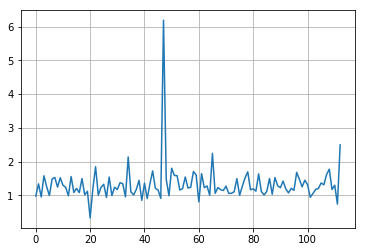

In [157]:
day = 3
ssstds = []
for j in np.arange(indexs[day], indexs[day+1], 1000):
    ssstds.append(np.std(datas[1][j:j+1000]))
plt.plot(ssstds)
plt.grid()
plt.show()

In [161]:
j = indexs[day] + 1000 * 47
print(np.std(datas[1][j:j+1000]))
datas[1][j:j+1000]

6.186267


array([-7.49682128e-01, -7.46459901e-01, -7.43244112e-01, -7.42260277e-01,
       -7.41364956e-01, -7.40563214e-01, -7.39860415e-01, -7.39262879e-01,
       -7.36949384e-01, -7.34663844e-01, -7.32407212e-01, -7.30180264e-01,
       -7.27984190e-01, -7.25819945e-01, -7.25695968e-01, -7.25717306e-01,
       -7.25894690e-01, -7.26239324e-01, -7.26764381e-01, -7.27483988e-01,
       -7.28413820e-01, -7.29571640e-01, -7.30976999e-01, -7.32651889e-01,
       -7.34621346e-01, -7.33662963e-01, -7.32795060e-01, -7.32023120e-01,
       -7.31352866e-01, -7.29022861e-01, -7.26698041e-01, -7.24378467e-01,
       -7.22063899e-01, -7.19754457e-01, -7.17449963e-01, -7.14265525e-01,
       -7.11621463e-01, -7.08993971e-01, -7.05820441e-01, -7.02651501e-01,
       -7.00046360e-01, -6.97458565e-01, -6.94299459e-01, -6.91144824e-01,
       -6.87994480e-01, -6.85705781e-01, -6.83421731e-01, -6.81142092e-01,
       -6.78867042e-01, -6.76596463e-01, -6.74330294e-01, -6.72068536e-01,
       -6.69811130e-01, -

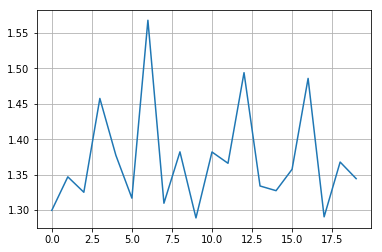

In [127]:
indexs = list(days_start_index) + [len(datas[1])]
rstds  = [np.std(datas[1][indexs[i]:indexs[i+1]]) for i in range(len(indexs)-1)]
plt.plot(rstds[:20])
plt.grid()
plt.show()

In [ ]:
# build model
from xtx_model import BaseMLP
from xtx_config import XTX_Config
mlp_model = BaseMLP(XTX_Config)
mlp_model.compile(metrics=None)

# train
batch_size, epochs, callbacks = mlp_model._parse_args(["batch_size", "epochs", "callbacks"])
history = mlp_model._model.fit(trains[0], trains[1]/1.15, 
                               validation_data=(vals[0], vals[1]/1.15),
                               batch_size=batch_size, epochs=epochs, callbacks=callbacks)

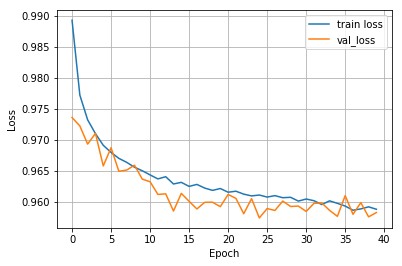

In [85]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

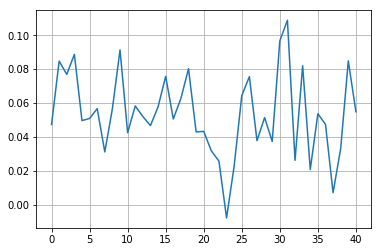

In [119]:
# predict
x, y, label_y, means, stds = datas
indexs = list(days_start_index) + [len(y)]
scores = []
for i in range(len(indexs)-1):
    sday = slice(indexs[i], indexs[i+1])
    pred_y = mlp_model.predict(x[sday])
    pred_y = pred_y[:, 0] * stds[sday] * 1.15 + means[sday]
    scores.append(score(label_y[sday], pred_y))
plt.plot(scores)
plt.grid()
plt.show()

In [120]:
for ds, n in zip([trains, vals, tests], ['trian', 'val', 'test']):
    pred_y = mlp_model.predict(ds[0])[:, 0]
    print("%s_score: %.4f" %(n, score(ds[2], pred_y * ds[4] * 1.15 + ds[3])))

trian_score: 0.0558
val_score: 0.0553
test_score: 0.0543
